# Installing keras tuner

In [1]:
pip install keras_tuner

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from keras.datasets import fashion_mnist
from sklearn.model_selection import KFold
from keras.utils import to_categorical
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD
from numpy import mean
from numpy import std
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Building Necessary Functions

In [3]:
def load_dataset():
    #load the dataset
    print('====================load_dataset========================')
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    print('--------------------Dataset is loaded')

    #reshape dataset to have a single channel
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test =  x_test.reshape((x_test.shape[0], 28, 28, 1))
    print('--------------------Dataset is reshaped')

    #convert from integer to float
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('--------------------Dataset is converted to float')

    #normalize to range 0-1
    x_train /= 255.0
    x_test /= 255.0
    print('--------------------Dataset is normalized')

    #onehot encode target values
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print('--------------------Dataset is onhot-encoded')

    #return
    print('====================load_dataset is finished============')
    return x_train, y_train, x_test, y_test

In [4]:
def show_picture():
    print('====================show_picture========================')
    # load dataset
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


    labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    sample = 1902 
    each = x_train[sample]

    print('Colorbar sample of dataset:')
    plt.figure(figsize=(3,3))
    plt.imshow(each)
    plt.colorbar()
    plt.show()
    print("Image (#{}): Which is label number '{}', or label '{}''".format(sample,y_train[sample], labelNames[y_train[sample]]))

    print('\n\n')

    print('Sample Images of dataset:')
    ROW = 7
    COLUMN = 7
    plt.figure(figsize=(10, 10)) 
    for i in range(ROW * COLUMN):
        temp = random.randint(0, len(x_train)+1)
        image = x_train[temp] 
        plt.subplot(ROW, COLUMN, i+1)       
        plt.imshow(image, cmap='gray')  
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(labelNames[y_train[temp]])
        plt.tight_layout()   
        
    plt.show()
    print('====================show_picture is finished============')

In [5]:
def baseline_cnn_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))           
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))


    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model

In [6]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 16),
            kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
            activation = 'relu',
            input_shape = (28, 28, 1)
        ),

        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value = 32, max_value = 128, step = 16),
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            activation = 'relu'
        ),

        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value = 32, max_value = 128, step = 16),
            activation = 'relu'
        ),

        keras.layers.Dense(10, activation = 'softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
def evaluate_model(x, y, num_folds=5):
    print('====================evaluate_model===========================')
    scores = []
    histories = []
    
    # prepare cross validation
    kfold = KFold(num_folds, shuffle=True, random_state=1)

    print('====================baseline_cnn_model=======================')
    # enumerate splits
    for train, test in kfold.split(x):
    
        # define model
        model = baseline_cnn_model()
    
        # select rows for train and test
        x_train, y_train, x_test, y_test = x[train], y[train], x[test], y[test]
        
        # fit model
        history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=0)
        
        # evaluate model
        _, acc = model.evaluate(x_test, y_test, verbose=0)
        print('> %.3f' % (acc * 100.0))

        # append scores
        scores.append(acc)
        histories.append(history)
    print('====================baseline_cnn_model is finished===========')
    print('====================evaluate_model is finished===============')
    return scores, histories

In [8]:
def summarize_diagnostics(histories):
    print('====================summarize_diagnostics====================')
    
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    
    pyplot.show()
    print('====================summarize_diagnostics is finished========')

In [9]:
def summarize_performance(scores):
    print('====================summarize_performance====================')

    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
    print('====================summarize_performance is finished====================')

In [10]:
def save_model():
    print('====================save_model===============================')
    #load the dataset
    x_train, y_train, x_test, y_test = load_dataset()

    #creat model
    model = baseline_cnn_model()

    #fit the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)

    #save the model
    model.save('final_model.h5')

    print('====================save_model is finished===================')

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def CM_output():
    print('===========Confusion Matrix and Classification Report========')
    #load the dataset
    x_train, y_train, x_test, y_test = load_dataset()

    #creat model
    model = baseline_cnn_model()
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(y_test,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])



    classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    print(classification_report(Y_true, Y_pred_classes, target_names = classes))

    print('====Confusion Matrix and Classification Report is finished===')

In [13]:
def run():
    #load the dataset
    x_train, y_train, x_test, y_test = load_dataset()

    print('\n\n\n')

    #show some pictures
    show_picture()

    print('\n\n\n')

    #evaluating model
    scores, histories = evaluate_model(x_train, y_train)

    print('\n\n\n')

    # learning curves
    summarize_diagnostics(histories)

    print('\n\n\n')

    # summarize estimated performance
    summarize_performance(scores)

    print('\n\n\n')

    #save the model
    save_model()

    # load model
    model = load_model('final_model.h5')

    # evaluate model on test dataset
    print('evaluate model on test dataset:\n')
    _, acc = model.evaluate(x_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))

    print('\n\n\n')

    CM_output()

    


# Running Part 1 to 4

====================load_dataset========================
--------------------Dataset is loaded
--------------------Dataset is reshaped
--------------------Dataset is converted to float
--------------------Dataset is normalized
--------------------Dataset is onhot-encoded
====================load_dataset is finished============




====================show_picture========================
Colorbar sample of dataset:


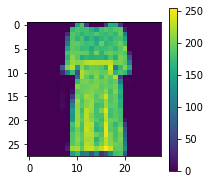

Image (#1902): Which is label number '3', or label 'Dress''



Sample Images of dataset:


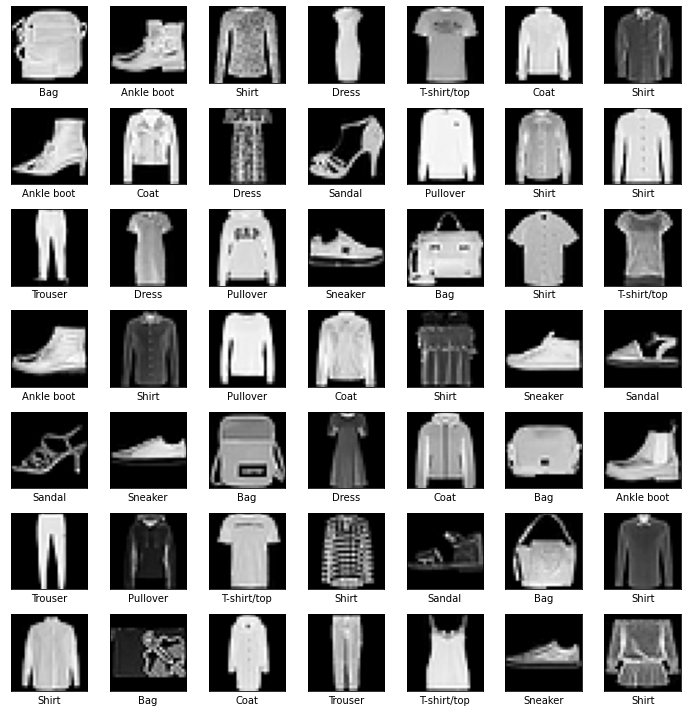

====================show_picture is finished============




====================evaluate_model===========================
====================baseline_cnn_model=======================
> 91.925
> 92.250
> 91.625
> 92.258
> 91.925
====================baseline_cnn_model is finished===========
====================evaluate_model is finished===============




====================summarize_diagnostics====================


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


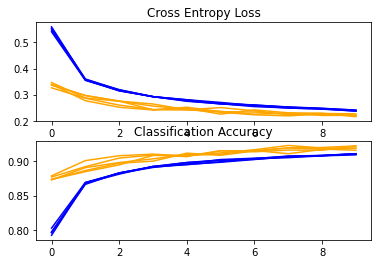

====================summarize_diagnostics is finished========




====================summarize_performance====================
Accuracy: mean=91.997 std=0.237, n=5


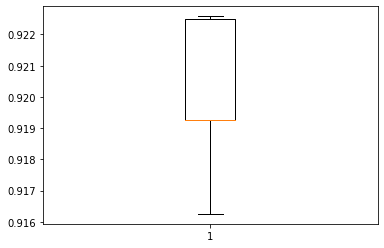

====================summarize_performance is finished====================




====================save_model===============================
====================load_dataset========================
--------------------Dataset is loaded
--------------------Dataset is reshaped
--------------------Dataset is converted to float
--------------------Dataset is normalized
--------------------Dataset is onhot-encoded
====================load_dataset is finished============
====================save_model is finished===================
evaluate model on test dataset:

> 91.720




===========Confusion Matrix and Classification Report========
====================load_dataset========================
--------------------Dataset is loaded
--------------------Dataset is reshaped
--------------------Dataset is converted to float
--------------------Dataset is normalized
--------------------Dataset is onhot-encoded
====================load_dataset is finished============


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 T-shirt/Top       0.00      0.00      0.00      1000
     Trouser       0.13      0.08      0.10      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.07      0.57      0.12      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.55      0.11      0.18      1000
         Bag       0.00      0.00      0.00      1000
  Ankle Boot       0.21      0.10      0.13      1000

    accuracy                           0.09     10000
   macro avg       0.10      0.09      0.05     10000
weighted avg       0.10      0.09      0.05     10000

====Confusion Matrix and Classification Report is finished===


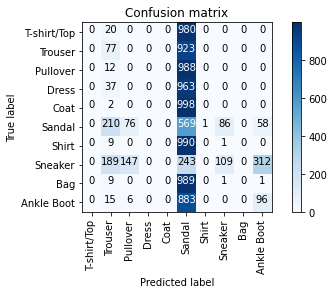

In [14]:
run()

# Running Part 5
## Hyperparameter Tuning

In [15]:
#load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#preprocess
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)

In [16]:
#Random search to find best hyperparameter
tuner_search = RandomSearch(build_model,
                            objective = 'val_accuracy',
                            max_trials = 10, directory = 'output', project_name = 'Mnist Fashion')

tuner_search.search(train_images, train_labels, epochs=3,validation_split=0.1)

INFO:tensorflow:Reloading Oracle from existing project output/Mnist Fashion/oracle.json
INFO:tensorflow:Reloading Tuner from output/Mnist Fashion/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [17]:
model = tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 48)        480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       55424     
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 80)                5898320   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                810       
Total params: 5,955,034
Trainable params: 5,955,034
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_images, train_labels, epochs=3, validation_split=0.1)

Epoch 1/3
1688/1688 [==============================] - 10s 6ms/step - loss: 0.1031 - accuracy: 0.9621 - val_loss: 0.2763 - val_accuracy: 0.9125
Epoch 2/3
1688/1688 [==============================] - 9s 6ms/step - loss: 0.0640 - accuracy: 0.9776 - val_loss: 0.2960 - val_accuracy: 0.9170
Epoch 3/3
1688/1688 [==============================] - 9s 6ms/step - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.3436 - val_accuracy: 0.9168


actual label:  9
predicted label:  9


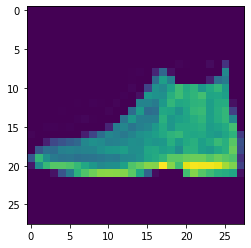

In [19]:
#Make predictions
predictions = model.predict(test_images)

plt.imshow(test_images[0].reshape(28,28))
print('actual label: ', test_labels[0])
print('predicted label: ', np.argmax(predictions[0]))

actual label:  4
predicted label:  4


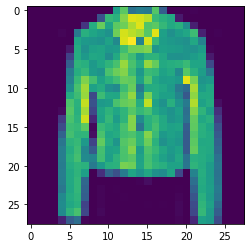

In [20]:
plt.imshow(test_images[10].reshape(28,28))
print('actual label: ', test_labels[10])
print('predicted label: ', np.argmax(predictions[10]))